In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
from scipeds.data.queries import QueryFilters, TaxonomyRollup
from scipeds.data.completions import CompletionsQueryEngine
from scipeds.data.enums import FieldTaxonomy, AwardLevel

from pathlib import Path

import pandas as pd

In [3]:
db_path = Path('data/processed/scipeds_0_0_4.duckdb')

In [4]:
engine = CompletionsQueryEngine(db_path=db_path)

In [5]:
qf = QueryFilters(start_year=1984, end_year=1994)


First let's diagnose the problem -- how many of the CIP codes (converted to their cip2020 version) in the 1984-1994 data are unknown / not in NCSES?

In [6]:
df = engine.field_totals_by_grouping(grouping='gender', query_filters=qf, taxonomy=FieldTaxonomy.cip, by_year=True)
df = df.reset_index()
df.head()

,cip2020,gender,year,field_degrees_within_gender,field_degrees_total,uni_degrees_within_gender,uni_degrees_total
0,01.0000,men,1984,1779,2354,983227,1991889
1,01.0000,men,1985,1649,2222,980838,2004285
2,01.0000,men,1986,1451,1974,975329,2008295
3,01.0000,men,1987,1218,1705,1036892,2163263
4,01.0000,men,1988,1192,1644,1112371,2324652


In [7]:
cipdf = engine.get_cip_table()
cipdf[cipdf['cip_title'] == "Unknown"]

,cip_title,ncses_sci_group,ncses_field_group,ncses_detailed_field_group,nsf_broad_field,dhs_stem
cip2020,,,,,,
02.0207,Unknown,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Non-science and engineering,False
02.0302,Unknown,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Non-science and engineering,False
02.0303,Unknown,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Non-science and engineering,False
02.0304,Unknown,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Non-science and engineering,False
02.0306,Unknown,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Non-science and engineering,False
...,...,...,...,...,...,...
61.2701,Unknown,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Non-science and engineering,False
61.2707,Unknown,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Non-science and engineering,False
61.2801,Unknown,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Not categorized in NCSES crosswalk,Non-science and engineering,False


In [8]:
df_w_cip = pd.merge(
    df, cipdf,
    left_on=FieldTaxonomy.cip, left_index=False,
    right_index=True, 
    validate='many_to_one'
)
df_w_cip.head()

,cip2020,gender,year,field_degrees_within_gender,field_degrees_total,uni_degrees_within_gender,uni_degrees_total,cip_title,ncses_sci_group,ncses_field_group,ncses_detailed_field_group,nsf_broad_field,dhs_stem
0,01.0000,men,1984,1779,2354,983227,1991889,"Agriculture, Agriculture Operations And Relate...",Science and engineering,Life Sciences,Agricultural Sciences,Agricultural and biological sciences,False
1,01.0000,men,1985,1649,2222,980838,2004285,"Agriculture, Agriculture Operations And Relate...",Science and engineering,Life Sciences,Agricultural Sciences,Agricultural and biological sciences,False
2,01.0000,men,1986,1451,1974,975329,2008295,"Agriculture, Agriculture Operations And Relate...",Science and engineering,Life Sciences,Agricultural Sciences,Agricultural and biological sciences,False
3,01.0000,men,1987,1218,1705,1036892,2163263,"Agriculture, Agriculture Operations And Relate...",Science and engineering,Life Sciences,Agricultural Sciences,Agricultural and biological sciences,False
4,01.0000,men,1988,1192,1644,1112371,2324652,"Agriculture, Agriculture Operations And Relate...",Science and engineering,Life Sciences,Agricultural Sciences,Agricultural and biological sciences,False


In [9]:
# How many unique unclassified CIPs per year?
df_w_cip[df_w_cip['cip_title'] == "Unknown"][['year', FieldTaxonomy.cip]].drop_duplicates().groupby('year').size()

year
1984    123
1985    132
1986    129
1987     52
1988     41
1989     42
1990     48
1991     39
1992      1
1993      1
1994      1
dtype: int64

In [10]:
# How many total CIPs per year?
df_w_cip[['year', FieldTaxonomy.cip]].drop_duplicates().groupby('year').size()

year
1984    806
1985    819
1986    814
1987    754
1988    742
1989    744
1990    747
1991    739
1992    829
1993    829
1994    825
dtype: int64

Ok so for earlier years it's like half of the CIPs that aren't classified.

We need to figure out why these CIPs aren't being classified. Likely becuase they're not in the 85 -> 90 classifier?

In [11]:
unknown_cips = df_w_cip[df_w_cip['cip_title'] == "Unknown"][['year', FieldTaxonomy.cip]].drop_duplicates()
unknown_cips.head()

,year,cip2020
1027,1984,02.0207
1028,1985,02.0207
1029,1986,02.0207
1033,1984,02.0302
1034,1985,02.0302


In [12]:
unknown_cips[unknown_cips[FieldTaxonomy.cip] == "01.0202"]

,year,cip2020


01.0202
- listed as "10202 - Agricultural Electrification Power and Controls" in the 1985 data dictionary.
- Only has one degree?

Let's see how many _students_ these unknowns represent per year

In [13]:
df_w_cip[df_w_cip['cip_title'] == "Unknown"][['year', FieldTaxonomy.cip, "field_degrees_total"]].drop_duplicates().groupby('year')["field_degrees_total"].sum()

year
1984     20380
1985     21083
1986     23703
1987      3981
1988     80657
1989    138020
1990     30948
1991     69562
1992     51136
1993     30515
1994     20746
Name: field_degrees_total, dtype: int64

Uhhh wait is that _all_ of the degrees in 1984?

In [14]:
df_w_cip[['year', 'uni_degrees_total']].drop_duplicates()

,year,uni_degrees_total
0,1984,1991889
1,1985,2004285
2,1986,2008295
3,1987,2163263
4,1988,2324652
5,1989,2412546
6,1990,2320375
7,1991,2408979
8,1992,2550460
9,1993,2616641


In [15]:
proportion_missing = pd.merge(
    df_w_cip[['year', 'uni_degrees_total']].drop_duplicates(),
    df_w_cip[df_w_cip['cip_title'] == "Unknown"][['year', FieldTaxonomy.cip, "field_degrees_total"]].drop_duplicates().groupby('year')["field_degrees_total"].sum(),
    right_index=True,
    left_on='year'
).rename(columns={'field_degrees_total': 'unknown_cip_total'})

proportion_missing['fraction_unknown_cips'] = proportion_missing['unknown_cip_total'] / proportion_missing['uni_degrees_total']

proportion_missing

,year,uni_degrees_total,unknown_cip_total,fraction_unknown_cips
0,1984,1991889,20380,0.010231
1,1985,2004285,21083,0.010519
2,1986,2008295,23703,0.011803
3,1987,2163263,3981,0.001840
4,1988,2324652,80657,0.034696
5,1989,2412546,138020,0.057209
6,1990,2320375,30948,0.013337
7,1991,2408979,69562,0.028876
8,1992,2550460,51136,0.020050
9,1993,2616641,30515,0.011662


Ok, let's start with the biggest unknowns for 84-86 and see if we can find them.

In [16]:
(
    df_w_cip[
        (df_w_cip['cip_title'] == "Unknown") & (df_w_cip['year'].isin([1984, 1985, 1986]))
    ]
    .groupby([FieldTaxonomy.cip])
    ['field_degrees_total']
    .sum()
).sort_values(ascending=False)

/var/folders/87/tp5jbk1x7zx0c0tx8zqvrxjr0000gp/T/ipykernel_61097/937130514.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([FieldTaxonomy.cip])


cip2020
07.0608    27320
50.0801    14874
47.0602    14642
20.0102     9914
15.0604     6398
           ...  
16.0906        0
16.0908        0
16.0999        0
16.1001        0
95.9500        0
Name: field_degrees_total, Length: 2518, dtype: int64

In [17]:
# Now 1990 is the worst offender, what's up?
(
    df_w_cip[
        (df_w_cip['cip_title'] == "Unknown") & (df_w_cip['year'].isin([1990, 1991]))
    ]
    .groupby([FieldTaxonomy.cip])
    ['field_degrees_total']
    .sum()
).sort_values(ascending=False)

/var/folders/87/tp5jbk1x7zx0c0tx8zqvrxjr0000gp/T/ipykernel_61097/1231911568.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([FieldTaxonomy.cip])


cip2020
95.0000    176038
20.0102     13134
20.0101      1878
61.2601      1428
20.0109      1230
            ...  
16.0402         0
16.0403         0
16.0406         0
16.0407         0
95.9500         0
Name: field_degrees_total, Length: 2518, dtype: int64

# 2/21 update:

Uhhh... 06.0401 is back to causing trouble. I've gotten all the other years way down, need to figure out what's up with the 1990 and 1991 CIPs but it's too late and my brain is tired.

06.0401 is in the CIP85toCIP90 crosswalk! 

`06.0401	Business Administration	52.0201	Business Administration & Management, General`

Oh, we just weren't reading in that crosswalk. Let's try adding that to the code and then...

Hm, now 06.0401 is being mapped correctly to its 1990 CIP code of 52.0201 but nothing after that.

In [18]:
cipdf.loc['52.0201']

cip_title                     Business Administration and Management, General
ncses_sci_group                                   Non-science and engineering
ncses_field_group                                     Business and Management
ncses_detailed_field_group                            Business and Management
nsf_broad_field                                   Non-science and engineering
dhs_stem                                                                False
Name: 52.0201, dtype: object

Ok it's being mapped from 1985 to 1990 correctly, but then it's not present in the 1990 crosswalk. Does that mean it should just be propagated? Or it needs to be in the dict?

Update: it was becuase the NCSES classifier was only classifying the original CIP code, not the 2020 one. And this original cip code (1) doesn't have a cip title (bc the original crosswalk file didn't have one) and (2) isn't in the NCSES classifier.

Ok so now we still have a bunch of missing codes, let's dig into those.

Update: the vast majority were "total" cips that weren't being seen. I fixed that.


Now it looks like the early 90's are most problematic. What's going on here? Let's look at 07.0305 as an example...

In [19]:
# cipdf.loc["07.0305"]

07.0305 Business Data Programming (from [here](https://nces.ed.gov/pubs91/91396.pdf))

Not finding it in the NSF data or in the Excel with all the crosswalks. Uh oh...

But also in that pdf, it looks like it SHOULD be in the 85 -> 90 crosswalk:

07.0305 52.1202 Business Computer Programming/Programmer

What about the next most common one, `17.0602`?

This one is also in the pdf but not in the Excel file...

Same with this guy: 43.0105

# Read the crosswalk from the CIP 90 pdf

https://nces.ed.gov/pubs91/91396.pdf

I then opened the pdf in preview and dragged 

In [20]:
import fitz  # PyMuPDF
from pathlib import Path
import pandas as pd

In [21]:


# Open the PDF file
pdf_path = Path("pipeline/assets/91396_subset.pdf")
doc = fitz.open(pdf_path)

# Extract text from all pages
pdf_text = '\n'.join([page.get_text("text") for page in doc])

pdf_text = pdf_text.split('\n')

pdf_text = pdf_text[16:]

# Remove the Chapter lines
ch_idx_to_remove = {
    'CHAPTER TWO': [-1, 1], # Ch. 2 has an empty string before the CHAPTER TWO line
    'CHAPTER THREE': [0, 1],
    'CHAPTER FOUR': [0, 1],
    'CHAPTER FIVE': [-1, 1],
    'CHAPTER SIX': [-1, 1]
}
rm_idxs = []
for k, v in ch_idx_to_remove.items():
    i = pdf_text.index(k)
    rm_idxs += list(range(i + v[0], i + v[1] + 1))

pdf_text = [t for i, t in enumerate(pdf_text) if i not in rm_idxs]

# Remove deleted CIP codes, they don't have a 90 CIP
deleted_idxs = [i for i, t in enumerate(pdf_text) if t == "Deleted"]
rm_idxs = []
for i in deleted_idxs:
    rm_idxs += [i-1, i]

pdf_text = [t for i, t in enumerate(pdf_text) if i not in rm_idxs]

# Remove one "Assign to Specific Hobby (see Appendix D)", also doesn't have a 90 CIP
deleted_idxs = [i for i, t in enumerate(pdf_text) if t == "Assign to Specific Hobby (see Appendix D)"]
rm_idxs = []
for i in deleted_idxs:
    rm_idxs += [i-1, i]

pdf_text = [t for i, t in enumerate(pdf_text) if i not in rm_idxs]

# Remove any remaining empty strings
pdf_text = [t for t in pdf_text if t != '']

# For some reason only one line got parsed incorrectly
idx = 1004
pdf_text = pdf_text[:idx] + [' '.join(pdf_text[idx:idx+8])] + pdf_text[idx+8:]

with open('extracted_text.txt', 'w') as f:
    f.write('\n'.join(pdf_text))

pdf_df = pd.DataFrame(
    data=[pdf_text[::3], pdf_text[1::3], pdf_text[2::3]],
    index=['CIP85', 'CIP90', 'CIP90TITLE']
).T.replace('', None).dropna(how='all')

pdf_df.head()


,CIP85,CIP90,CIP90TITLE
0,01.0101,01.0101,"Agricultural Business and Management, General"
1,01.0102,01.0102,Agricultural Business/Agribusiness Operations
2,01.0103,01.0103,Agricultural Economics
3,01.0104,01.0104,Farm and Ranch Management
4,01.0199,01.0199,"Agricultural Business and Management, Other"


In [22]:
pdf_df['CIP90'].str.len().unique()

array([7])

In [23]:
from pipeline.cip_crosswalk import CIPCodeCrosswalk

In [24]:
cw = CIPCodeCrosswalk()
cw._load_1985_to_1990_crosswalk()

In [25]:
original_crosswalk = cw.crosswalk[(1984, 1991)]['cip_map']
# original_crosswalk

In [26]:
pdf_crosswalk = dict(zip(pdf_df['CIP85'], pdf_df['CIP90']))
pdf_crosswalk = {k: v for k, v in pdf_crosswalk.items() if k != v}
# pdf_crosswalk

In [27]:
len(original_crosswalk), len(pdf_crosswalk)

(1093, 472)

In [28]:
# Keys present in both dictionaries
len(set(pdf_crosswalk.keys()) & set(original_crosswalk.keys()))

472

In [29]:
# Of the keys that are in both dicts, do they map to the same values?
dup_keys = list(set(pdf_crosswalk.keys()) & set(original_crosswalk.keys()))
sum([original_crosswalk[k] != pdf_crosswalk[k] for k in dup_keys])

4

In [53]:
[(k, original_crosswalk[k], pdf_crosswalk[k]) for k in dup_keys if original_crosswalk[k] != pdf_crosswalk[k]]

[('17.0499', '51.0301', '51.1599'),
 ('26.0201', '26.0202', '26.0203'),
 ('13.0801', '13.0802', '42.1701'),
 ('18.0701', '51.0701', '51.0702')]

17.0499 is in the pdf twice, one maps to 51.0301 (what the excel maps to) and the other maps to 51.1599... same with 13.0801

In all cases, I want to use the first mapping not the second.

# Missing 1990 codes

Ok, now that we've update the code to use the CIP crosswalk from the pdf, let's revisit what's missing:


In [35]:
proportion_missing = pd.merge(
    df_w_cip[['year', 'uni_degrees_total']].drop_duplicates(),
    df_w_cip[df_w_cip['cip_title'] == "Unknown"][['year', FieldTaxonomy.cip, "field_degrees_total"]].drop_duplicates().groupby('year')["field_degrees_total"].sum(),
    right_index=True,
    left_on='year'
).rename(columns={'field_degrees_total': 'unknown_cip_total'})

proportion_missing['fraction_unknown_cips'] = proportion_missing['unknown_cip_total'] / proportion_missing['uni_degrees_total']

proportion_missing

,year,uni_degrees_total,unknown_cip_total,fraction_unknown_cips
0,1984,1991889,20380,0.010231
1,1985,2004285,21083,0.010519
2,1986,2008295,23703,0.011803
3,1987,2163263,3981,0.001840
4,1988,2324652,80657,0.034696
5,1989,2412546,138020,0.057209
6,1990,2320375,30948,0.013337
7,1991,2408979,69562,0.028876
8,1992,2550460,51136,0.020050
9,1993,2616641,30515,0.011662


In [36]:
# Now 1990 is the worst offender, what's up?
(
    df_w_cip[
        (df_w_cip['cip_title'] == "Unknown") & (df_w_cip['year'].isin([1990, 1991]))
    ]
    .groupby([FieldTaxonomy.cip])
    ['field_degrees_total']
    .sum()
).sort_values(ascending=False)

/var/folders/87/tp5jbk1x7zx0c0tx8zqvrxjr0000gp/T/ipykernel_61097/1231911568.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([FieldTaxonomy.cip])


cip2020
95.0000    176038
20.0102     13134
20.0101      1878
61.2601      1428
20.0109      1230
            ...  
16.0402         0
16.0403         0
16.0406         0
16.0407         0
95.9500         0
Name: field_degrees_total, Length: 2518, dtype: int64

Hmm, 06.0401 is one that I thought I had already fixed. Maybe it's only in the 1985 -> 1990 crosswalk and not in the 1990 -> 2k crosswalk?

In [37]:
cw.crosswalk.keys()

dict_keys([(2010, 2019), (2000, 2009), (1990, 1999), (1984, 1991)])

In [38]:
'06.0401' in cw.crosswalk[(1990, 1999)]['cip_map']

False

In [39]:
'06.0401' in cw.crosswalk[(1984, 1991)]['cip_map']

True

In [40]:
cw.crosswalk[(1984, 1991)]['cip_map']['06.0401']

'52.0201'

In [41]:
tmp = (
    df_w_cip[
        (df_w_cip['cip_title'] == "Unknown") & (df_w_cip['year'].isin([1990, 1991]))
    ]
    .groupby([FieldTaxonomy.cip])
    ['field_degrees_total']
    .sum()
).sort_values(ascending=False).head(10)

for missing_cip in tmp.index:

    print(f"{missing_cip} in 90 -> 2k crosswalk: {missing_cip in cw.crosswalk[(1990, 1999)]['cip_map']}")
    print(f"{missing_cip} in 85 -> 90 crosswalk: {missing_cip in cw.crosswalk[(1984, 1991)]['cip_map']}")

95.0000 in 90 -> 2k crosswalk: False
95.0000 in 85 -> 90 crosswalk: False
20.0102 in 90 -> 2k crosswalk: False
20.0102 in 85 -> 90 crosswalk: True
20.0101 in 90 -> 2k crosswalk: False
20.0101 in 85 -> 90 crosswalk: True
61.2601 in 90 -> 2k crosswalk: False
61.2601 in 85 -> 90 crosswalk: False
20.0109 in 90 -> 2k crosswalk: False
20.0109 in 85 -> 90 crosswalk: True
20.0107 in 90 -> 2k crosswalk: False
20.0107 in 85 -> 90 crosswalk: True
61.0213 in 90 -> 2k crosswalk: False
61.0213 in 85 -> 90 crosswalk: False
60.0299 in 90 -> 2k crosswalk: False
60.0299 in 85 -> 90 crosswalk: False
60.0199 in 90 -> 2k crosswalk: False
60.0199 in 85 -> 90 crosswalk: False
60.0105 in 90 -> 2k crosswalk: False
60.0105 in 85 -> 90 crosswalk: False


/var/folders/87/tp5jbk1x7zx0c0tx8zqvrxjr0000gp/T/ipykernel_61097/159061316.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([FieldTaxonomy.cip])


Ok, so these are all in the 85 -> 90 crosswalk but not the 90 -> 99 crosswalk. So I need to use the 85 -> 90 crosswalk for 1990 and 1991 as well. (ugh)

Ok, now that I've used the 85 -> 90 crosswalk for my 1990 and 1991 data, 1988 and 1989 are still pretty bad offenders (5% of majors aren't in NCSES classification).

In [42]:
(
    df_w_cip[
        (df_w_cip['cip_title'] == "Unknown") & (df_w_cip['year'].isin([1988, 1989]))
    ]
    .groupby([FieldTaxonomy.cip])
    ['field_degrees_total']
    .sum()
).sort_values(ascending=False).head(10)


/var/folders/87/tp5jbk1x7zx0c0tx8zqvrxjr0000gp/T/ipykernel_61097/1938997181.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([FieldTaxonomy.cip])


cip2020
95.0000    415660
20.0102      7946
20.0101      5600
20.0107      1994
61.2601      1256
60.0199       552
60.0105       530
61.0213       484
60.0299       466
28.9999       332
Name: field_degrees_total, dtype: int64

AhA! There's a bunch of CIP 95.000. I think these are Unknown or Total?

Oh, maybe they're not Bachelor's. ChatGPT said this but can't find me a source: "The Classification of Instructional Programs (CIP) code 95.0000 corresponds to "High School/Secondary Diplomas and Certificates, Other." This category encompasses any high school or secondary-level diploma or certificate programs that don't fall under specific categories. The CIP is a taxonomic scheme developed by the U.S. Department of Education's National Center for Education Statistics (NCES) to support the accurate tracking and reporting of fields of study and program completions."

In [43]:
qf = QueryFilters(start_year=1984, end_year=1994, award_levels=[AwardLevel.bachelors])
df = engine.field_totals_by_grouping(grouping='gender', query_filters=qf, taxonomy=FieldTaxonomy.cip, by_year=True).reset_index()

df_w_cip = pd.merge(
    df, cipdf,
    left_on=FieldTaxonomy.cip, left_index=False,
    right_index=True, 
    validate='many_to_one'
)


proportion_missing = pd.merge(
    df_w_cip[['year', 'uni_degrees_total']].drop_duplicates(),
    df_w_cip[df_w_cip['cip_title'] == "Unknown"][['year', FieldTaxonomy.cip, "field_degrees_total"]].drop_duplicates().groupby('year')["field_degrees_total"].sum(),
    right_index=True,
    left_on='year'
).rename(columns={'field_degrees_total': 'unknown_cip_total'})

proportion_missing['fraction_unknown_cips'] = proportion_missing['unknown_cip_total'] / proportion_missing['uni_degrees_total']

proportion_missing

,year,uni_degrees_total,unknown_cip_total,fraction_unknown_cips
0,1984,986345,4575,0.004638
1,1985,990877,4448,0.004489
2,1986,1000204,4485,0.004484
3,1987,1005021,806,0.000802
4,1988,1009223,4945,0.004900
5,1989,1034535,6156,0.005950
6,1990,1068133,6180,0.005786
7,1991,1112534,17684,0.015895
8,1992,1171556,12775,0.010904
9,1993,1199042,10562,0.008809


Ok that is good enough for me! Below 1% missing for all years except 1991 (1.6%) and 1992 (1.1%)

# Check for malformatted cip codes

Chris found some CIP codes that don't seem right:

```
Something not quite right is happening with the mapping to cip2020 - I end up with string title values in the cip2020 column when I expect 6-digit CIPs.

One way to try to figure out what's going wrong is to see where any values in the mapping have more than 7 characters.
```

In [44]:
set([len(s) for s in cipdf.index])

{7}

In [45]:
set([len(s) for s in cw.crosswalk[(1984, 1991)]['cip_map'].keys()]) == {7}

True

In [46]:
cw.convert_to_cip2020(year=1991, codes="52.1202")

,cip2020,cip2020_title
0,11.0202,"Computer Programming, Specific Applications"


In [47]:
cw.crosswalk[(1984, 1991)]['cip_map']["07.0103"]

'52.0302'

In [48]:
cw.convert_to_cip2020(year=1985, codes="07.0103")

,cip2020,cip2020_title
0,52.0302,Accounting Technology/Technician and Bookkeeping


# Check all data

In [49]:
qf = QueryFilters(start_year=1984, end_year=2023, award_levels=AwardLevel.bachelors)

df = engine.field_totals_by_grouping(
    grouping='gender', taxonomy=FieldTaxonomy.ncses_field_group,
    query_filters=qf,
    by_year=True
)
df.head()

/Users/claireduvallet/github/sfa/scipeds/scipeds/data/queries.py:96: UserWarning: IPEDS award level coding and race and ethnicity coding changed between 2010 and 2011 datasets. For more details, see https://nces.ed.gov/ipeds/report-your-data/race-ethnicity-reporting-changes
  warnings.warn(


field_degrees_within_gender  \
ncses_field_group                     gender year                                
Architecture and Environmental Design men    1984                         5908   
                                             1985                         6032   
                                             1986                         5842   
                                             1987                         5633   
                                             1988                         5302   

                                                   field_degrees_total  \
ncses_field_group                     gender year                        
Architecture and Environmental Design men    1984                 9204   
                                             1985                 9342   
                                             1986                 9145   
                                             1987                 8982   
                                             1988                 8654   

                                                   uni_degrees_within_gender  \
ncses_field_group                     gender year                              
Architecture and Environmental Design men    1984                     486750   
                                             1985                     486660   
                                             1986                     490143   
                                             1987                     485823   
                                             1988                     483580   

                                                   uni_degrees_total  
ncses_field_group                     gender year                     
Architecture and Environmental Design men    1984             986345  
                                             1985             990877  
                                             1986            1000204  
                                             1987            1005021  
                                             1988            1009223

In [50]:
from scipeds.data.enums import NCSESFieldGroup

tmp = df.loc[NCSESFieldGroup.engineering].reset_index()


<Axes: xlabel='year'>

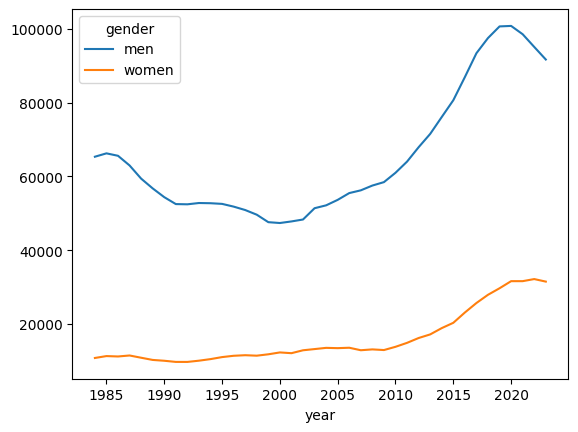

In [51]:
tmp.pivot(index='year', columns='gender', values='field_degrees_within_gender').plot()

<Axes: xlabel='year'>

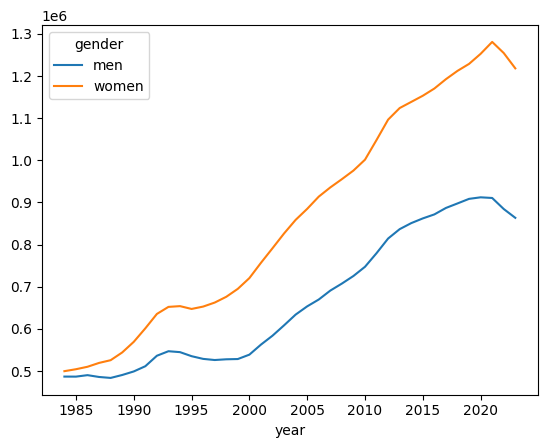

In [52]:
tmp.pivot(index='year', columns='gender', values='uni_degrees_within_gender').plot()

Looks continuous enough to me. Let's work on downloading _all_ the data and reprocessing from scratch there.